In [29]:
import numpy as np
from scipy.ndimage import gaussian_filter1d as g1d
from scipy.stats import norm
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from matplotlib import cm


# ISGRI  Calibration Reconstruction Invariance

## ISGRI observation space and general reconstruction basics


$Observation$ (e.g. `ISGRI` spectral histograms) can be represented as transformation of some true $Model$ with $Response$:

$$
Observation~=~ Response \times Model
$$

Note that $Observation$ does not belong to the same space as $Model$. For example, when $Model$ is vectors of flux in incident photon energy bins, $Observation$ is detected 
counts in detector channels. 

For `ISGRI`, each pixel detector channels are biparametric, described by $\mathrm{ISGRI\_PHA}$ and $\mathrm{ISGRI\_RT}$ integers. `ISGRI` stores channel values for each event, but it is often useful to consider histogram of these detected values.

$$
CountSpectrum\left[\mathrm{ISGRI\_PHA,~ISGRI\_RT}\right] = \sum_{Energy, Coordinate}~Response\left[\mathrm{ISGRI\_PHA,~ISGRI\_RT},~\mathrm{Energy, Coordinate}\right] \times ModelFlux\left[\mathrm{Energy, Coordinate}\right]
$$

Where $CountSpectrum$ is histogram from channel values as directly returned by the pixels. 

Here we assume that $CountSpectrum$ is additive. This assumption is almost always valid, except when dead time effects due to source rate are relevant. The latter occurred, for example, in an extremely high-flux short bursts, and can be somewhat easily treated. To simplify the notation we disregard this possibility in what follows.

This equation is valid for a single pixel at single moment of time. All pixels differ, and also evolve, in long term as well as in short disruptions of several different kinds.
Were we assume that $ModelFlux$ is constant in time, and there is only one source in the sky; this is reasonable since here we are primarily concerned with spectral reconstruction (see however the [NOMEX section](sec:nomex)). 
So it is almost always necessary to conside that

$$
CountSpectrum\left[\mathrm{Channel}\right] = \sum_{Energy}~Response\left[\mathrm{Channel},~\mathrm{Energy}\right] \times ModelFlux\left[\mathrm{Energy}\right]
$$

where

$$
\mathrm{Channel} = \left[\mathrm{ISGRI\_PHA,~ISGRI\_RT,~ISGRI\_PIXEL,~Time}\right]
$$


It means that `ISGRI` spectra are, in principle, always 4-dimensional. `ISGRI` is not unique in this, many other instruments/telescopes are in a similar situation, though not many have an extra dimension fo pulse properties (the rise time).

When defined in this way, the entire transformation from the incident flux to observation is contained in the response function $Response$.

A 4-dimensional $Observation$ space becomes quite large, and $Response$ is even larger. Assuming that detector variations in $\mathrm{Time}$ are at most at 100~second timescale, there are $2048 \times 256 \times 128 \times 128 \times 24 \times 3600 / 100$ there are in total about $10^{13}$ bins in a $CountSpectrum$. There are only $10^{8}$ `ISGRI` photons per day, so this spectrum is mostly empty. Without changing the essence of the approach, it is more feasible to compare time-tagged events. In this case, it is still necessary to compute per-event response, accounting for all 4 detector variables. This approach extracts the most out of ISGRI data, but is quite computationally expensive. It was exploited in [\[1\]]() for about 1-second long event with very fine time structure. It does not currently appear very realistic to apply this method to multi-day observations. And even it if was feasible, it would not bring any benefits, since major uncertainty in ISGRI is associated with response uncertainties.

Luckily, since the $Model$ space is only 1-dimensional (for a single constant source) it is possible, with only some loss of information, to reduce the size of the observation space to 1 dimension, $CountSpectrum$ in some reconstructed channel, $\mathrm{ISGRI\_ENERGY}$. 

The transformation can be done with 

$$
CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right] = \sum_{\mathrm{Channel}}~Reconstruction\left[\mathrm{ISGRI\_ENERGY, Channel}\right] \times CountSpectrum\left[\mathrm{Channel}\right]
$$

in order to preserve the relation between data and model

$$
CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right] = \sum_{Energy}~Response\left[\mathrm{ISGRI\_ENERGY},~\mathrm{Energy}\right] \times ModelFlux\left[\mathrm{Energy}\right]
$$

response should satisfy 

$$
ResponseRec\left[\mathrm{ISGRI\_ENERGY, Energy}\right] = \sum_{\mathrm{Channel}}~Reconstruction\left[\mathrm{ISGRI\_ENERGY, Channel}\right] \times Response\left[\mathrm{Channel, Energy}\right]
$$


```{note}
Note that all this is valid for any $Reconstruction$ function. Using some peculiar $Reconstruction$ it is possible to build a very unusual but still valid channel spectra in $\mathrm{ISGRI\_ENERGY}$ which will yeild accurate $Model$. 

This constitutes **considerable invariance of accurate inferrence on $Reconstruction$ process**

In practice, reconstruction segmented and is selected to:
* reduce information loss (e.g. improve resolution - reduce overlap between useful representations of interesting variables in the reconstructed space TODO) 
* fit scientific intuition
* reduce dependence on systematic uncertainties

All this is only relevant when some reconstruction is applied, i.e. when complete forward folding is not possible (see e.g. [here](threeML) for complete forward process).
```

For example degenerate $Reconstruction$ which discards any information about other variables but $\mathrm{ISGRI\_PHA}$ will produce not an unreasonable spectrum. This spectrum will have rather washed-out (broadened) spectral features and will evolve with time even for a constant source. Appropriate response would have to be incorporate in a suitable response.

In `ISGRI`, $ChannelReconstruction$ has two kinds of anomalous properties:
* $\mathrm{ISGRI\_ENERGY}$ is a monotonous function of $\mathrm{ISGRI\_PHA}$ only below some critical $\mathrm{ISGRI\_RT}_{reversal}$. This is because high-depth high-energy interactions produce high RT and low PHA, and PHA may be come lower than that of a low-energy interaction (which reach large RT due to RT resolution, without out much change in PHA).
* absorbtion edges at 30 keV

In both cases, to avoid using irregular function, it is sufficient to choose simpler reconstrciton.
It may seem that these anomalies, especially that at 30 keV, could help in characterizing the instrument. Unfortunately, the expected features in the data are quite `TODO: describe`

```{warning}
Note that even with some motivated $Reconstruction$, the reconstructed channel $\mathrm{ISGRI\_ENERGY}$ is very different from incident photon energy. 
In principle, the reconstruction may be selected so that $\mathrm{ISGRI\_ENERGY}$ approximates incident $\mathrm{Energy}$. This would correspond to some optimal $Reconstruction_{optimal}$.
```

While any $Reconstruction$ discards information, some of them will provide more information than the other. It is, therefore, possible to pick optimal maximally-informative $Reconstruction_{optimal}$ (see below).

We are interested in particular [\[2\]]() case of this transformation, which enables relation between original and reconstructed channels:

$$
\mathrm{ISGRI\_ENERGY} = ChannelReconstruction\left[\mathrm{Channel}\right] \\
$$


If $CountSpectrum$ is an arbitrary function of $Channel$, some $ChannelReconstruction$ may be incompatible with single-valued $Reconstruction$ functions. Clearly, if $CountSpectrum$ changes as function of $\mathrm{Channel}$ along tranjectories of constant $\mathrm{ISGRI\_ENERGY}$, single-valued $CountSpectrumRec\left[\mathrm{ISGRI\_ENERGY}\right]$ can not exist.

If $CountSpectrum$ is the density on $\mathrm{Channel}$ space, it will satisfy

$$
CountSpectrumRec\left[ChannelReconstruction\left[\mathrm{Channel}\right]\right] \times ChannelReconstruction'\left[\mathrm{Channel}\right] = CountSpectrum\left[\mathrm{Channel}\right]
$$

This equation can be solved together with [the one above](fig) to derive $CountSpectrumRec$.
Note, however, that **this condition is intentionally not satisfied in `ISGRI`**.

## Structure of ISGRI $Reconstruction$

(here and everywhere in this note, channel variable names correspond to those used in `OSA`, bold, etc TODO)


As described above, there is a lot if freedom in how the reconstruction is done, as long as the response is generate accordingly. It might be desirable to follow some optimalily and regularily conditions, and we will apply in part at the end of this note.

Historically, the reconstruction process in `ISGRI` was intented ad-hoc following scietific intuition. The result is not far from optimal.
It consists of multiple stages.

$$
\mathrm{ISGRI\_ENERGY} = (\mathrm{LUT2} \circ \mathrm{LUT1}) \left[\mathrm{Channel}\right]\\
$$
$$
CountSpectrumRec = (\mathrm{NOMEX} \circ \mathrm{Imaging} \circ \mathrm{Uniformity} \circ \mathrm{PixelEfficiency}) \left[CountSpectrum\right]
$$

Below each component is described briefly, clarifying which dimensions they discard, and what optimizations are selected:

#### `LUT1` reconstruction


$$
LUT1\left[Time\right]: \mathrm{ISGRI\_PHA , ISGRI\_PIXEL}  \Rightarrow  \mathrm{ISGRI\_PHA1},  \mathrm{ISGRI\_RISE} \Rightarrow \mathrm{ISGRI\_RT}
$$

* `LUT1` discards $\mathrm{ISGRI\_PIXEL}$ dimension
* It uses detector temperature, which is a function of `Time`.
* The transformation is optimizing energy resolution. It does not explicitly depend on time (except for the temperature). 
* Resulting $\mathrm{ISGRI\_PHA1}$ values are close to those average $\mathrm{ISGRI\_PHA}$.

#### `LUT2` reconstruction

$$
LUT2\left[Time\right]: \mathrm{ISGRI\_PHA1, ISGRI\_RT}  \Rightarrow  \mathrm{ISGRI\_ENERGY}
$$

`LUT2` discards $\mathrm{ISGRI\_RT}$ dimension (since `OSA11`, it is a function function of `Time`), and optimizes to:
* Iprove energy resolution
* Make response have a strong diagonal component: photopeak interactions reconstruct $\mathrm{ISGRI\_ENERGY}$ close to incident `Energy` 

Before `OSA11`, `LUT2` did not depend on time. Instead, a different correction was applied before `LUT2`.

#### `PixelEffieciency` reconstruction

$$
Imaging: CountSpectrumRec\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec1\left[\mathrm{ISGRI\_PIXEL, Energy}\right]
$$


Each `ISGRI` pixel has a low-PHA threshold. Most the the pixels have threshold settings around 15. Specific $\mathrm{ISGRI\_PHA}$ threshold value is different, but made to match $\mathrm{ISGRI\_PHA}$ of about 15 keV at the early mission. 

The threshold is not sharp, it a smooth function, with width similar to the resolution. 
Pixel settings change slightly every orbit.

The function depends on the pixel setting and pixel type (there are two pixel types). Pixel setting and kind are the best tracers of divergence between pixel response. ![pic here]()

There is no straightforward way to predict this function preciesly, while it is also necessary, since low-energy efficiency is the single strongest factor in the entire spectral reconstruction. It also affects imaging quality at the lowest energies.

```{note}
`PixelEffieciency` simultaneously affects spectral and imaging performance, which might compete. Before OSA11, spectral reconstruction from was rather theoretical and approximate, and time-dependent $Response$ was accounting for spectral variations. With OSA11, `PixelEffieciency` is calibrated in-flight.
```

```{warning}
`PixelEfficiency` divides $CountSpectrum$ by some theoretical or calibrated function, with no change to the channel variable.
 t this time, reconstructed count rate $CountSpectrumRec1$ no more has the meaning of number of counts in some channel rate. Imaging and NOMEX corrections futher exhaugurate this condition. Other X-ray instruments typically choose to avoid this sort of transformation, since it complicates intepretation. But in coded-mask instruments, with strongly overlapping `PSF`, it can be useful.
```

`PixelEfficiency` is selected to make sure that:
* $CountSpectrumRec1$ of a source with constant flux does not change very much with mission life time
* `PIF` are compatible with what would be expected from if all pixels were identical (note interplay with NOMEX)

It would be possible to rely more on `PixelEfficiency` even before `OSA11`. But before several reconstruction troubles were addressed which time-dependent `LUT2`, it was very hard to model reasonably-structured efficiency.

#### `Uniformity` reconstruction

Uniformity is equivalent to another component of `PixelEffieciency`. It is currently set to all unity values (i.e. disabled)

#### `Imaging` reconstruction

$$
Imaging: CountSpectrumRec1\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec2\left[\mathrm{SkySource, Energy}\right]
$$

This reconstruction converts functions of detector pixel into functions of sky locations. Position-dependent factors are introduced at this time, so that:

* $CountSpectrumRec2$ represents count rate the same source if it was for on-axis with all-open mask and no NOMEX. TODO

Due to energy-dependence of `Imaging`, it needs to use mostly incident `Energy` values, for example to compute opacity of mask elements, shield, etc. But these values are not known at this stage. So instead, `Imaging` simply uses $\mathrm{ISGRI\_ENERGY}$. For example, photon with $\mathrm{Energy}$ = 200 keV will no trouble getting through the shield, but it is most likely to deposit lower energy, e.g. $\mathrm{ISGRI\_ENERGY}$ == 30 keV, and the opacity used for this photon will be much higher than was actually experienced.

Luckily, this is usually sufficient, since energy dependence is not large at low energy (where reconstruction precision requirements are the highest). Also since most sources are soft, for $\mathrm{ISGRI\_ENERGY}$ = 30 keV, only a minority of photos will have much higher incident energy, and they can be disregarded in the reconstruction. Similarly, for $\mathrm{ISGRI\_ENERGY}$ = 200 keV, most photons will come from $\mathrm{Energy}$ = 200 keV. I.e. for soft sources, average $\mathrm{ISGRI\_ENERGY}$ in a bin is a good indicator of average $\mathrm{Energy}$. For particularly hard sources, this might not be the case.

#### `NOMEX` reconstruction

$$
Imaging: CountSpectrumRec2\left[\mathrm{ISGRI\_PIXEL, Energy}\right]  \Rightarrow  CountSpectrumRec\left[\mathrm{SkySource, Energy}\right]
$$

Nomex is a structure supporting the mask. Its opacity is especially difficult to model, and was calibrated in-flight. In principle, it is part of `Imaging`, and subject to the same issues, just on a larger scale. Average transparency of NOMEX at 30 keV is about 30%. TODO:check

#### Summary 

All the above corrections aim to make `Response` as constant as possible. In this process, simple and conventional meaning of the `CountSpectrum` as event histogram is lost. Resulting `CountSpectrumRec` spectrum becomes almost constant, but additional freedom in energy-dependent (but not time-dependent) normalization remains. 
This normalization is selected to satisfy some additional conditions, which are poorly satisfied due to historical reasons. In any case, these conditions are difficult to interpret for a regular user.

The only correction which has to remain in Response, is resolution. Indeed it is not possible to fully reconstruct-out broading of the spectrum (it is possible, but not advisable, to make all spectra equally broead and keep the response identical throughout the mission).


assuming no systematic errors. Probably ok


[]

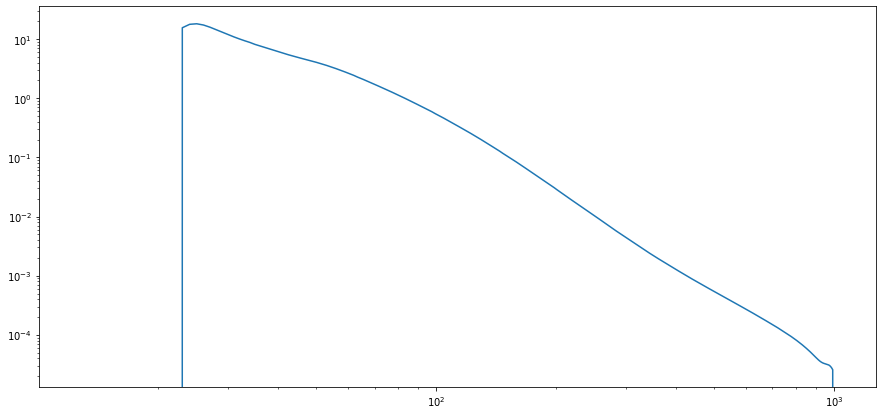

In [34]:
import importlib
from astropy.io import fits
import numpy as np
import sys
import os
sys.path.insert(0, os.path.join(os.getenv('HOME'), 'ogip'))

import ogip
import ogip.tools
import ogip.spec

effi = fits.open('/isdc/arc/rev_3/ic/ibis/mod/isgr_effc_mod_0011.fits')[1].data[11]
ebds = fits.open('/isdc/arc/rev_3/ic/ibis/rsp/isgr_ebds_mod_0002.fits')[1].data
matrix = fits.open('/isdc/arc/rev_3/ic/ibis/rsp/isgr_rmf_rsp_0043.fits')['ISGR-RMF.-RSP'].data
ce1, ce2 = ebds['E_MIN'], ebds['E_MAX']
e1, e2 = matrix['ENERG_LO'], matrix['ENERG_HI']
rmf = ogip.spec.RMF.from_arrays(e1, e2, np.stack(matrix['MATRIX']), ce1, ce2)

ogip.spec.PHAI.from_arrays(
    exposure=1000,
    rate=np.ones_like(ce1),
    stat_err=np.ones_like(ce1),
)

rate = ogip.tools.convolve(
    ogip.tools.crab_ph_cm2_s_kev,
    rmf,
)

plt.figure(figsize=(15,7))

plt.plot(
    ce1, rate/(ce2-ce1)
)

plt.loglog()

## Misreconstruction

## Changing from one reconstruction to another: relation between $ChannelReconstruction$ and $Reconstruction$: 






Relation between $ChannelReconstruction$ and $Reconstruction$ 

$$
TODO
$$



## Optimal transfomration

In [ ]:
# TODO: measure or mimick gain from HE line alone, and from LE line alone. find which one mismatches

# TODO:
# * reconstruct with det
# * reconstruct with det and morph

# TODO: 
# reconstruct effi
# reconstruct lut2
# reconstruct rsp

